*Note - For most convenient use, upload notebook to google colab and use the index on the left in colab, showing the sections and subsections*

In this file , we are loading many of the models that were saved during the course of this project and doing analysis, like plotting the learning curve, computing precision@k and recall@k for some of the datasets, showing differences between SGD and ALS on the same model for few of the datasets. We have created seperate sections below for each of the models. Each saved model consists of- 
1. user vectors and item vectors which can be used to predict ratings
2. user mapping and item mappings which can be used to get user id and itemid as in the original dataset
3. training and validation losses saved in a list for plotting learning curves
4. the best_validation_mae value, the value for which model was saved. 
5. In some cases, we also save a summary of the gridsearch we performed with learning rate, regularization rate and number of factors. In these cases we load those files and display them as well. In these files we can see which hyperparameters were used and which ones gave the best validaion MAE value







# Importing and Installing required libraries and modules

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from numpy import random
from sklearn.utils import shuffle
import math
import pickle
# import tensorflow as tf
import gzip
import json
import itertools
from itertools import product
import time
import collections
from collections import defaultdict

import seaborn as sns

time: 5.9 ms (started: 2021-05-04 18:13:26 +00:00)


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 230 µs (started: 2021-05-04 14:27:06 +00:00)


# Methods to Run before executing train or predict

### Preprocessing and Splitting into train-test

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def read_Dataset(path):
    return getDF(path)


def Preprocessing(df, min_user_ratings ,min_item_ratings):
    df_copy  = df[df.groupby(['uid']).uid.transform('count')>=min_user_ratings].copy()
    df_copy = df_copy[df_copy.groupby('iid').uid.transform('count')>=min_item_ratings].copy()
    
    # Assigning ids to values
    user_mapping = {v: k for k, v in enumerate(set(df_copy.uid))}
    item_mapping = {v: k for k, v in enumerate(set(df_copy.iid))}
    
    # Mapping user id, item id strings to sequential integer values
    df_copy.uid = df_copy.uid.map(user_mapping)
    df_copy.iid = df_copy.iid.map(item_mapping)
    
    return df_copy, user_mapping, item_mapping


def train_test_split(df_copy):
    train_list = []
    test_list =  []
    surprise_list = []
    size = 0
    user_groups = df_copy.sort_values('timestamp')   # to make sure , for every user, the test set ratings are the most recent
    for user, df in user_groups.groupby("uid"):
        train_size = round(0.8*len(df))
        train_list.append(df[:train_size])
        test_list.append(df[train_size:])
    return pd.concat(train_list), pd.concat(test_list)



time: 34.3 ms (started: 2021-05-04 14:27:06 +00:00)


### SGD Implementation

#### Training with combination of all parameters - best model with least validation mae will be chose and saved

In [4]:
def SGD(train, test, hyperparameters, file_name, num_epochs, user_mapping, item_mapping, results_df, min_user_rated,min_item_rated):
        
    best_validation_mae = math.inf
    for i, params in enumerate(list(itertools.product(*hyperparameters))):
        early_stopping_count = 0
        lr = params[0]
        reg = params[1]
        n_factors = params[2]
         # Initialization of Vectors
        p = random.rand(len(user_mapping), n_factors)
        q = random.rand(n_factors, len(item_mapping))

        train_mae = [0 for _ in range(num_epochs)]
        train_mse = [0 for _ in range(num_epochs)]
        test_mae = [0 for _ in range(num_epochs)]
        test_mse = [0 for _ in range(num_epochs)]
        print(f'\nTrying with hyperparameters - Learning Rate - {lr}, Regularization(Lambda) - {reg}, No. of Factors/rank - {n_factors}')
        for epoch in range(num_epochs):
          
            # Training 
            for i, row  in train.iterrows():
                # e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                p[int(row.uid),:] = p[int(row.uid),:] + lr*(e_ij*q[:,int(row.iid)].T - reg*p[int(row.uid),:])
                q[:,int(row.iid)] = q[:,int(row.iid)] + lr*(e_ij*p[int(row.uid),:].T - reg*q[:,int(row.iid)])
                train_mae[epoch] += abs(e_ij)
                train_mse[epoch] += e_ij**2
            
            # Validation 
            for i, row  in test.iterrows():
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                test_mae[epoch] += abs(e_ij)
                test_mse[epoch] += e_ij**2
            if test_mae[epoch] < best_validation_mae:
                best_validation_mae = test_mae[epoch]
                SGD_model = { 'name':file_name, 'user_vectors':p,'item_vectors':q,
                                           'hyperparameters':params, 'train':train,'test':test, 'train_mse':train_mse,'train_mae':train_mae,
                                           'test_mse':test_mse, 'test_mae':test_mae,
                                                'best_train_mae':train_mae[epoch],'best_test_mae':test_mae[epoch],
                                            'user_mapping':user_mapping, 'item_mapping':item_mapping}
            # Early stopping criteria
            
            if test_mae[epoch] >= test_mae[epoch-1] and epoch > 0:
                early_stopping_count += 1
            else:
                early_stopping_count = 0
            
            if early_stopping_count > 5:
                break
                
            # Displaying Loss Function Values
            print(f'\nEpoch {epoch} - \n')
            print(f'Training Error (MAE) {round(train_mae[epoch]/len(train),3)} (MSE) {round(train_mse[epoch]/len(train), 3)}', end='\t')
            print(f'Validation Error (MAE) {round(test_mae[epoch]/len(test),3)} (MSE) {round(test_mse[epoch]/len(test), 3)}')
            

        pickle.dump(SGD_model, open( file_name, "wb" ) )
        hyperparam_all = {'lr':hyperparameters[0],'reg':hyperparameters[1],'factors':hyperparameters[2]}
        results_df.loc[len(results_df)] =[SGD_model['name'],len(SGD_model['train']),len(SGD_model['test']),SGD_model['best_train_mae']/len(train),SGD_model['best_test_mae']/len(test),hyperparam_all,params,min_item_rated,min_user_rated]
    return results_df

time: 69.6 ms (started: 2021-05-04 14:27:06 +00:00)


## ALS Algorithm

#### Training ALS algorithm with combination of hyperparameters

In [5]:

def ALS(train, test, hyperparameters, file_name, num_epochs, user_mapping, item_mapping, results_df, min_user_rated,min_item_rated):
    best_validation_mae = math.inf
    for i, params in enumerate(list(itertools.product(*hyperparameters))):
        lr = params[0]
        reg = params[1]
        n_factors = params[2]
        
        # Initialization of Vectors
        p = random.uniform(-1,1,(len(user_mapping), n_factors))
        q = random.uniform(-1,1,(n_factors, len(item_mapping)))
        
        # List to hold training and validation losses
        train_mae = [0 for _ in range(num_epochs)]
        train_mse = [0 for _ in range(num_epochs)]
        test_mae = [0 for _ in range(num_epochs)]
        test_mse = [0 for _ in range(num_epochs)]
        print(f'\nTrying with hyperparameters - {lr}, {reg}, {n_factors}')
        users_ratings = train.groupby('uid')
        items_ratings = train.groupby('iid')
        for epoch in range(num_epochs):
            
            # Training
            for user, df in users_ratings:
                item_ids = df.iid.tolist()
                p[int(user),:] = np.matmul(np.linalg.inv(np.sum([np.outer(q[:,int(item)], q[:,int(item)].T) 
                                 for item in item_ids], axis = 0) + reg*np.eye(n_factors)),
                                 np.sum([df.loc[df.iid==item].iloc[0].ratings*q[:,int(item)] 
                                 for item in item_ids], axis = 0))   
            for item, df in items_ratings:
                user_ids = df.uid.tolist()
                q[:,int(item)] = np.matmul(np.linalg.inv(np.sum([np.outer(p[int(user),:], p[int(user),:].T) 
                                 for user in user_ids], axis = 0) + reg*np.eye(n_factors)),
                                 np.sum([df.loc[df.uid==user].iloc[0].ratings*p[int(user),:] 
                                 for user in user_ids], axis = 0))  
            for i, row in train.iterrows():
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                train_mae[epoch] += abs(e_ij)
                train_mse[epoch] += (e_ij**2)
            
            # Validation
            for i, row  in test.iterrows():
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                test_mae[epoch] += abs(e_ij)
                test_mse[epoch] += (e_ij**2)
            if test_mae[epoch] < best_validation_mae:
                best_validation_mae = test_mae[epoch]
                ALS_model = { 'name':file_name, 'user_vectors':p,'item_vectors':q,
                                               'hyperparameters':params, 'train':train,'test':test, 'train_mse':train_mse,'train_mae':train_mae,
                                               'test_mse':test_mse, 'test_mae':test_mae,
                                                'best_train_mae':train_mae[epoch],'best_test_mae':test_mae[epoch],
                                                'user_mapping':user_mapping, 'item_mapping':item_mapping}
                
                
            print(f'Epoch {epoch} (MAE) {round(train_mae[epoch]/len(train),3)} (MSE) {round(train_mse[epoch]/len(train), 3)}', end='\t')
            print(f'Epoch {epoch} loss (MAE) {round(test_mae[epoch]/len(test),3)} (MSE) {round(test_mse[epoch]/len(test), 3)}')   
            # Displaying Loss Function Values
            pickle.dump(ALS_model, open(file_name, "wb"))
        hyperparam_all = {'lr':hyperparameters[0],'reg':hyperparameters[1],'factors':hyperparameters[2]}   
        results_df.loc[len(results_df)] =[ALS_model['name'],len(ALS_model['train']),len(ALS_model['test']),ALS_model['best_train_mae']/len(train),ALS_model['best_test_mae']/len(test),hyperparam_all,params,min_item_rated,min_user_rated]
    return results_df 

time: 77.6 ms (started: 2021-05-04 14:27:06 +00:00)


## Recommend Method

In [6]:
def recommend(model, n, name_mapping, user_id):
    p  = model['user_vectors']
    q  = model['item_vectors']
    test_dataset = model['test']
    train_dataset = model['train']
    already_rated = pd.concat([train_dataset, test_dataset])

    item_mapping = model['item_mapping']
    user_mapping = model['user_mapping']
    item_reverse_map = {v: k for k, v in item_mapping.items()}

    df = train_dataset.groupby('uid').get_group(user_mapping[user_id])
    rated_items = df.iid.tolist()
    print(user_id)
    user_id = user_mapping[user_id]
    predicted_rating = {}
    for item, item_id in item_mapping.items():
        if item_id not in rated_items:
            if item in name_mapping.keys():
              item_name  = name_mapping[item]
            else:
              item_name = 'none'
            predicted_rating[item] = (item_name, p[int(user_id), :].dot(q[:,int(item_id)]))

    t = sorted(predicted_rating.items(), key=lambda x:-x[1][1])[:n]
    for x in t:
      print("{0}: {1}".format(*x))
    return t

time: 16.1 ms (started: 2021-05-04 14:27:06 +00:00)


# Loading Saved Models for analysis

## Office Products 5-core 2018 dataset - SGD Analysis

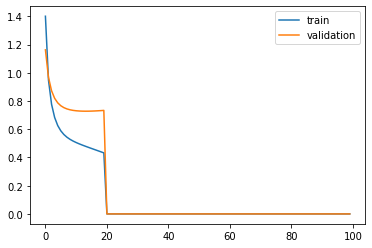

time: 274 ms (started: 2021-05-04 18:44:31 +00:00)


In [90]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Office_Products_5.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

Results Summary

In [91]:
results_df = pickle.load(open('/content/Office_Products_5_2018',"rb"))
results_df

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Office_Products_5.p,594358,146186,0.47952,0.727771,"{'lr': [0.01], 'reg': [0.01], 'factors': [10, ...","(0.01, 0.01, 10)",2,2
1,SGD_Office_Products_5.p,594358,146186,0.47952,0.727771,"{'lr': [0.01], 'reg': [0.01], 'factors': [10, ...","(0.01, 0.01, 20)",2,2
2,SGD_Office_Products_5.p,594358,146186,0.47952,0.727771,"{'lr': [0.01], 'reg': [0.01], 'factors': [10, ...","(0.01, 0.01, 50)",2,2


time: 34.9 ms (started: 2021-05-04 18:44:33 +00:00)


In [92]:
# Apply function to compute predicted rating by loaded model vectors and append column
p = model_sgd["user_vectors"]
q = model_sgd["item_vectors"]
user_mapping = model_sgd["user_mapping"]
item_mapping = model_sgd["item_mapping"]
test_set['SGD_predicted'] = test_set.apply(lambda row: np.dot(p[int(row.uid),:],q[:,int(row.iid)].T), axis=1)

time: 4.32 s (started: 2021-05-04 18:44:34 +00:00)


In [93]:
# we create another copy of test set with 
test_set_10 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 10]

time: 22.6 ms (started: 2021-05-04 18:44:38 +00:00)


Following is the number of users with more than 10 ratings

In [94]:
len(test_set_10.uid.unique())

157

time: 7.23 ms (started: 2021-05-04 18:44:40 +00:00)


Hit ratio with 20 items

In [95]:
# recommended_list = [[]for _ in test_set_100.uid.unique()] # for each user in the test_set_15 set find the hit rate - no. of relevant items recommended
# for i, user_id in enumerate(test_set_100.uid.to_list()):
#   recommened_list[i] = recommend(model_sgd, 100, item_name_mapping, user_id)

time: 1.32 ms (started: 2021-05-04 18:44:42 +00:00)


Recall@k and Precision@k, k = 5, threshold = 3, for all users who have rated atleast 10 items

In [96]:
threshold = 3

# we create another copy of test set with users having rated atleast 15 items
test_set_15 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 15]


# relevant items  and recommended items
def precision_and_recalls_atK(df, threshold, k = 5):
  # First map the predictions to each user.
  user_est_true = defaultdict(list)
  for i,row in df.iterrows():
        user_est_true[row.uid].append((row.SGD_predicted, row.ratings))

  for uid, user_ratings in df.groupby('uid'):
    relevant_df = user_ratings[user_ratings.ratings > threshold]
    recommend_df = user_ratings[user_ratings.SGD_predicted > threshold]
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


time: 47.6 ms (started: 2021-05-04 18:44:44 +00:00)


In [97]:
precisions, recalls = precision_and_recalls_atK(test_set_10, threshold)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.973
0.364
time: 214 ms (started: 2021-05-04 18:44:45 +00:00)


Recall@k and Precision@k, k = 5, threshold = 4, for all users who have rated atleast 10 items

In [98]:
precisions, recalls = precision_and_recalls_atK(test_set_10, 4)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.92
0.359
time: 224 ms (started: 2021-05-04 18:44:47 +00:00)


Recall@k and Precision@k, k = 3, threshold = 4, for all users who have rated atleast 5 items

In [99]:
# we create another copy of test set with 
test_set_5 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 5]
precisions, recalls = precision_and_recalls_atK(test_set_10, 4, 3)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.92
0.22
time: 214 ms (started: 2021-05-04 18:44:48 +00:00)


RMSE for test set

In [100]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rms = mean_squared_error(test_set.ratings, test_set.SGD_predicted, squared=False)
mae = mean_absolute_error(test_set.ratings, test_set.SGD_predicted)
print(rms)
print(mae)  # this is same as was obtained during training as our test set is the validation set.

1.0566935848962713
0.7333835154935548
time: 7.09 ms (started: 2021-05-04 18:44:50 +00:00)


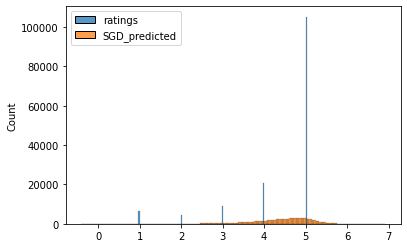

time: 1.87 s (started: 2021-05-04 18:44:52 +00:00)


In [101]:
sns.histplot([test_set.ratings,test_set.SGD_predicted])

## Office Products 5 2014 dataset - SGD and ALS analysis

Training and validation curve of the SGD model

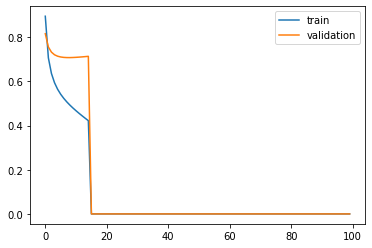

time: 178 ms (started: 2021-05-04 18:52:13 +00:00)


In [111]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Office_Products_5_2014.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

Training and Validation Curve of the ALS model

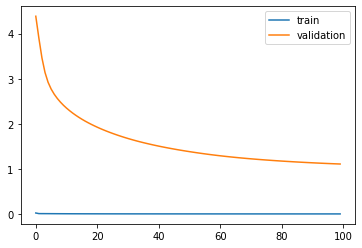

time: 191 ms (started: 2021-05-04 18:52:17 +00:00)


In [112]:
# read model and plot graph
model_als = pickle.load(open('/content/ALS_Office_Products_5_2014.p','rb'))
train_set = model_als['train']
test_set = model_als['test']
train_mae = model_als['train_mae']
test_mae = model_als['test_mae']
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [127]:
print(f'No. of unique users {len(user_mapping.keys())}')
print(f'No. of unique items {len(item_mapping.keys())}')
print(f'trainset, validation set size {len(model_sgd["train"])},{len(model_sgd["test"])}')
print(f'trainset, validation set size {len(model_als["train"])},{len(model_als["test"])}')

No. of unique users 4905
No. of unique items 2420
trainset, validation set size 42792,10466
trainset, validation set size 42792,10466
time: 6.61 ms (started: 2021-05-04 19:13:19 +00:00)


Results Summary - SGD, ALS

In [113]:
results_df_als = pickle.load(open('/content/Office_Products_5_2014_ALS',"rb"))
results_df_als

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Office_Products_5_2014.p,42792,10466,0.462810,0.743206,"{'lr': [0.01], 'reg': [0.01], 'factors': [10, ...","(0.01, 0.01, 10)",1,1
1,SGD_Office_Products_5_2014.p,42792,10466,0.493083,0.708315,"{'lr': [0.01], 'reg': [0.01], 'factors': [10, ...","(0.01, 0.01, 20)",1,1
2,SGD_Office_Products_5_2014.p,42792,10466,0.493083,0.708315,"{'lr': [0.01], 'reg': [0.01], 'factors': [10, ...","(0.01, 0.01, 50)",1,1
3,ALS_Office_Products_5_2014.p,42792,10466,0.100963,1.996975,"{'lr': [0.01], 'reg': [0.1], 'factors': [10, 2...","(0.01, 0.1, 10)",1,1
4,ALS_Office_Products_5_2014.p,42792,10466,0.059003,1.339042,"{'lr': [0.01], 'reg': [0.1], 'factors': [10, 2...","(0.01, 0.1, 10)",1,1
5,ALS_Office_Products_5_2014.p,42792,10466,0.015684,1.286889,"{'lr': [0.01], 'reg': [0.1], 'factors': [10, 2...","(0.01, 0.1, 20)",1,1
6,ALS_Office_Products_5_2014.p,42792,10466,0.011731,1.115687,"{'lr': [0.01], 'reg': [0.1], 'factors': [10, 2...","(0.01, 0.1, 50)",1,1


time: 38.8 ms (started: 2021-05-04 18:52:20 +00:00)


Appending predicted ratings from ALS and SGD models

In [114]:
# Apply function to compute predicted rating by loaded model vectors and append column
p = model_sgd["user_vectors"]
q = model_sgd["item_vectors"]
user_mapping = model_sgd["user_mapping"]
item_mapping = model_sgd["item_mapping"]
test_set['SGD_predicted'] = test_set.apply(lambda row: np.dot(p[int(row.uid),:],q[:,int(row.iid)].T), axis=1)

time: 265 ms (started: 2021-05-04 18:52:23 +00:00)


In [115]:
p = model_als["user_vectors"]
q = model_als["item_vectors"]
user_mapping = model_als["user_mapping"]
item_mapping = model_als["item_mapping"]
test_set['ALS_predicted'] = test_set.apply(lambda row: np.dot(p[int(row.uid),:],q[:,int(row.iid)].T), axis=1)

time: 293 ms (started: 2021-05-04 18:52:27 +00:00)


In [116]:
test_set.head()

,uid,iid,ratings,timestamp,SGD_predicted,ALS_predicted
29054,0,339,3.0,1397088000,4.677600,4.509259
50641,0,2410,5.0,1403740800,4.777131,4.090994
20262,0,1289,5.0,1403740800,4.717684,4.080285
42611,1,2123,4.0,1356912000,5.156367,1.944690
40814,2,2022,5.0,1347235200,4.986567,3.663172


time: 16.3 ms (started: 2021-05-04 18:52:28 +00:00)


In [117]:
# we create another copy of test set with 
test_set_10 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 10]

time: 8.64 ms (started: 2021-05-04 19:01:51 +00:00)


Following is the number of users with more than 10 ratings

In [118]:
len(test_set_10.uid.unique())

25

time: 6.49 ms (started: 2021-05-04 19:01:53 +00:00)


Hit ratio with 20 items

In [ ]:
# recommended_list = [[]for _ in test_set_100.uid.unique()] # for each user in the test_set_15 set find the hit rate - no. of relevant items recommended
# for i, user_id in enumerate(test_set_100.uid.to_list()):
#   recommened_list[i] = recommend(model_sgd, 100, item_name_mapping, user_id)

time: 1.32 ms (started: 2021-05-04 18:44:42 +00:00)


Recall@k and Precision@k, k = 5, threshold = 3, for all users who have rated atleast 10 items

In [119]:
precisions, recalls = precision_and_recalls_atK(test_set_10, threshold)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.96
0.393
time: 35.8 ms (started: 2021-05-04 19:02:00 +00:00)


Recall@k and Precision@k, k = 5, threshold = 4, for all users who have rated atleast 10 items

In [120]:
precisions, recalls = precision_and_recalls_atK(test_set_10, 4)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.92
0.415
time: 35.5 ms (started: 2021-05-04 19:02:03 +00:00)


Recall@k and Precision@k, k = 3, threshold = 4, for all users who have rated atleast 5 items

In [121]:
# we create another copy of test set with 
test_set_5 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 5]
precisions, recalls = precision_and_recalls_atK(test_set_10, 4, 3)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.92
0.251
time: 41.3 ms (started: 2021-05-04 19:02:05 +00:00)


RMSE for test set

In [124]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rms = mean_squared_error(test_set.ratings, test_set.SGD_predicted, squared=False)
mae = mean_absolute_error(test_set.ratings, test_set.SGD_predicted)
rms_als = mean_squared_error(test_set.ratings, test_set.ALS_predicted, squared=False)
mae_als = mean_absolute_error(test_set.ratings, test_set.ALS_predicted)
print(rms)
print(mae)  # this is same as was obtained during training as our test set is the validation set.
print(rms_als)
print(mae_als)

0.9512180888773092
0.7140308636819402
1.4754390313217922
1.1156867484120399
time: 20.8 ms (started: 2021-05-04 19:03:18 +00:00)


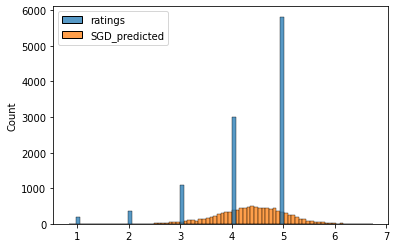

time: 663 ms (started: 2021-05-04 19:03:40 +00:00)


In [125]:
sns.histplot([test_set.ratings,test_set.SGD_predicted])

## 5-core combined datasets
Both SGD and ALS were run on combined 8-core datasets -
1. AMAZON FASHION
2. All Beauty
3. Appliances
4. Luxury Beauty
5. Software
6. Magazine Subscriptions
7. Industrial and Scientific
8. Gift cards


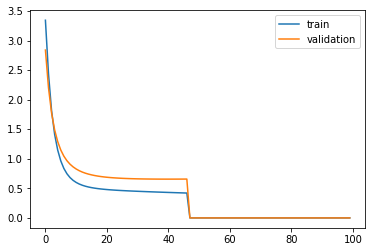

time: 211 ms (started: 2021-05-04 19:23:09 +00:00)


In [129]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Combined_8_Datasets_5_core.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

Training and Validation Curve of the ALS model

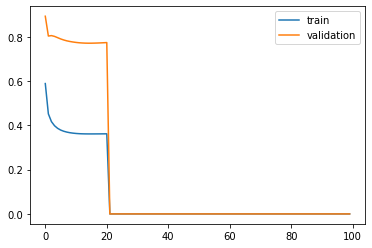

time: 333 ms (started: 2021-05-04 19:23:54 +00:00)


In [130]:
# read model and plot graph
model_als = pickle.load(open('/content/ALS_Combined_8_Datasets_5_core.p','rb'))
train_set = model_als['train']
test_set = model_als['test']
train_mae = model_als['train_mae']
test_mae = model_als['test_mae']
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [132]:
print(f'No. of unique users {len(model_sgd["user_mapping"].keys())}')
print(f'No. of unique items {len(model_sgd["item_mapping"].keys())}')
print(f'trainset, validation set size {len(model_sgd["train"])},{len(model_sgd["test"])}')
print(f'trainset, validation set size {len(model_als["train"])},{len(model_als["test"])}')

No. of unique users 18102
No. of unique items 8186
trainset, validation set size 99335,25232
trainset, validation set size 99335,25232
time: 3.77 ms (started: 2021-05-04 19:24:49 +00:00)


Results Summary - SGD, ALS

In [134]:
results_df_als = pickle.load(open('/content/5_core_Combined_results_8_datasets_als.p',"rb"))
results_df_als

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,ALS_Combined_8_Datasets_5_core.p,99335,25232,0.361331,0.771119,"{'lr': [0.01], 'reg': [1], 'factors': [2, 5, 20]}","(0.01, 1, 2)",1,1
1,ALS_Combined_8_Datasets_5_core.p,99335,25232,0.361331,0.771119,"{'lr': [0.01], 'reg': [1], 'factors': [2, 5, 20]}","(0.01, 1, 5)",1,1
2,ALS_Combined_8_Datasets_5_core.p,99335,25232,0.361331,0.771119,"{'lr': [0.01], 'reg': [1], 'factors': [2, 5, 20]}","(0.01, 1, 20)",1,1


time: 31.1 ms (started: 2021-05-04 19:26:28 +00:00)


In [136]:
results_df_sgd = pickle.load(open('/content/5_core_Combined_results_8_datasets.p',"rb"))
results_df_sgd

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Combined_8_Datasets_5_core.p,99335,25232,0.452896,0.662271,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 2)",1,1
1,SGD_Combined_8_Datasets_5_core.p,99335,25232,0.452896,0.662271,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 5)",1,1
2,SGD_Combined_8_Datasets_5_core.p,99335,25232,0.309486,0.658582,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 20)",1,1
3,SGD_Combined_8_Datasets_5_core.p,99335,25232,0.430854,0.655787,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 2)",1,1
4,SGD_Combined_8_Datasets_5_core.p,99335,25232,0.430854,0.655787,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 5)",1,1
5,SGD_Combined_8_Datasets_5_core.p,99335,25232,0.430854,0.655787,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 20)",1,1


time: 36.1 ms (started: 2021-05-04 19:30:02 +00:00)


Appending predicted ratings from ALS and SGD models

In [137]:
# Apply function to compute predicted rating by loaded model vectors and append column
p = model_sgd["user_vectors"]
q = model_sgd["item_vectors"]
user_mapping = model_sgd["user_mapping"]
item_mapping = model_sgd["item_mapping"]
test_set['SGD_predicted'] = test_set.apply(lambda row: np.dot(p[int(row.uid),:],q[:,int(row.iid)].T), axis=1)

time: 631 ms (started: 2021-05-04 19:30:28 +00:00)


In [138]:
p = model_als["user_vectors"]
q = model_als["item_vectors"]
user_mapping = model_als["user_mapping"]
item_mapping = model_als["item_mapping"]
test_set['ALS_predicted'] = test_set.apply(lambda row: np.dot(p[int(row.uid),:],q[:,int(row.iid)].T), axis=1)

time: 751 ms (started: 2021-05-04 19:30:31 +00:00)


In [139]:
test_set.head()

,uid,iid,ratings,timestamp,SGD_predicted,ALS_predicted
66489,0,3383,5.0,1470960000,3.015044,3.908310
10564,0,3908,5.0,1505779200,3.874626,4.878887
34366,1,206,5.0,1441152000,5.159510,4.318079
64536,1,1681,5.0,1486512000,3.644022,4.475553
1212,2,197,5.0,1369526400,5.396424,4.983642


time: 19.5 ms (started: 2021-05-04 19:30:34 +00:00)


In [142]:
# we create another copy of test set with 
test_set_10 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 8]

time: 14.6 ms (started: 2021-05-04 19:30:47 +00:00)


Following is the number of users with more than 10 ratings

In [143]:
len(test_set_10.uid.unique())

49

time: 6.84 ms (started: 2021-05-04 19:30:48 +00:00)


Hit ratio with 20 items

In [ ]:
# recommended_list = [[]for _ in test_set_100.uid.unique()] # for each user in the test_set_15 set find the hit rate - no. of relevant items recommended
# for i, user_id in enumerate(test_set_100.uid.to_list()):
#   recommened_list[i] = recommend(model_sgd, 100, item_name_mapping, user_id)

time: 1.32 ms (started: 2021-05-04 18:44:42 +00:00)


Recall@k and Precision@k, k = 3, threshold = 3, for all users who have rated atleast 10 items

In [144]:
precisions, recalls = precision_and_recalls_atK(test_set_10, threshold, 3)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.912
0.253
time: 60.2 ms (started: 2021-05-04 19:31:08 +00:00)


Recall@k and Precision@k, k = 5, threshold = 4, for all users who have rated atleast 10 items

In [146]:
precisions, recalls = precision_and_recalls_atK(test_set_10, 3, 3)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.912
0.253
time: 61.4 ms (started: 2021-05-04 19:31:20 +00:00)


Recall@k and Precision@k, k = 3, threshold = 4, for all users who have rated atleast 5 items

In [147]:
# we create another copy of test set with 
test_set_5 = test_set[test_set['uid'].map(test_set['uid'].value_counts()) > 5]
precisions, recalls = precision_and_recalls_atK(test_set_10, 4, 3)
# Precision and recall can then be averaged over all users
print(round(sum(prec for prec in precisions.values()) / len(precisions),3))
print(round(sum(rec for rec in recalls.values()) / len(recalls),3))

0.673
0.217
time: 64.3 ms (started: 2021-05-04 19:31:22 +00:00)


RMSE for test set

In [148]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rms = mean_squared_error(test_set.ratings, test_set.SGD_predicted, squared=False)
mae = mean_absolute_error(test_set.ratings, test_set.SGD_predicted)
rms_als = mean_squared_error(test_set.ratings, test_set.ALS_predicted, squared=False)
mae_als = mean_absolute_error(test_set.ratings, test_set.ALS_predicted)
print(rms)
print(mae)  # this is same as was obtained during training as our test set is the validation set.
print(rms_als)
print(mae_als)

1.4607727925302203
1.0991307929552814
1.1713557500990026
0.7739361607519394
time: 15 ms (started: 2021-05-04 19:31:25 +00:00)


In [159]:
print(round(model_sgd["best_test_mae"]/len(model_sgd["test"]),4))

0.6558
time: 1.61 ms (started: 2021-05-04 19:34:04 +00:00)


## Software 5-core 2018 dataset - analysis with changing min_user_rated and min_item_rated

Here, since this is a small dataset, we have run the SGD algorithm multiple times varying the minimum no. of items users has rated

### Model 1 - Minimum Items User must have rated  - 5, min users that must have rated item - 2

no. of users 1459
no. of items 747


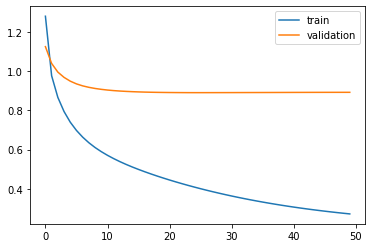

time: 196 ms (started: 2021-05-04 20:01:34 +00:00)


In [164]:
# read model and plot graph
model_sgd = pickle.load(open('/content/5Core_5User_2Item.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

Corresponding summary for above models

In [166]:
results_df_sgd = pickle.load(open('/content/Software_5_results_summary',"rb"))
results_df_sgd['df_name'] = 'SGD_Software_5' # correcting error
results_df_sgd.head()

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Software_5,8404,2014,0.630374,0.932870,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 2)",5,2
1,SGD_Software_5,8404,2014,0.568143,0.929708,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 5)",5,2
2,SGD_Software_5,8404,2014,0.400961,0.890206,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 20)",5,2
3,SGD_Software_5,8404,2014,0.400961,0.890206,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 2)",5,2
4,SGD_Software_5,8404,2014,0.400961,0.890206,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 5)",5,2


time: 35.3 ms (started: 2021-05-04 20:03:16 +00:00)


### Model2 - Minimum Items User must have rated - 5, min users that must have rated item - 5

no. of users 1459
no. of items 682


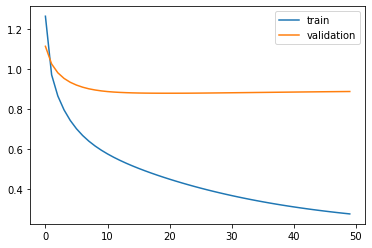

time: 189 ms (started: 2021-05-04 20:03:44 +00:00)


In [167]:
# read model and plot graph
model_sgd = pickle.load(open('/content/5Core_5User_5Item.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [169]:
results_df_sgd = pickle.load(open('/content/Software_5_results_summary_2',"rb"))
results_df_sgd['df_name'] = 'SGD_Software_5' # correcting error
results_df_sgd

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Software_5,8234,1985,0.633834,0.950659,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 2)",5,5
1,SGD_Software_5,8234,1985,0.596090,0.945914,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 5)",5,5
2,SGD_Software_5,8234,1985,0.449861,0.878578,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 20)",5,5
3,SGD_Software_5,8234,1985,0.449861,0.878578,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 2)",5,5
4,SGD_Software_5,8234,1985,0.449861,0.878578,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 5)",5,5
5,SGD_Software_5,8234,1985,0.449861,0.878578,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 20)",5,5


time: 34.4 ms (started: 2021-05-04 20:04:23 +00:00)


## Digital Music_5 2018 dataset - SGD




no. of users 13256
no. of items 11626


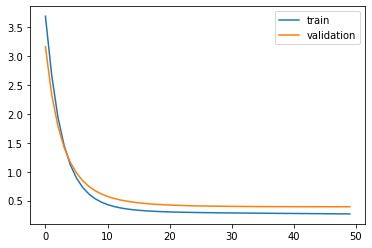

time: 215 ms (started: 2021-05-04 20:12:54 +00:00)


In [170]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Digital_Music_2018.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [171]:
results_df_sgd = pickle.load(open('/content/Digital_Music_5_results_summary_2',"rb"))
# results_df_sgd['df_name'] = 'SGD_Software_5' # correcting error
results_df_sgd

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Digital_Music.p,107039,26031,0.302842,0.407857,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 2)",5,2
1,SGD_Digital_Music.p,107039,26031,0.302842,0.407857,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 5)",5,2
2,SGD_Digital_Music.p,107039,26031,0.302842,0.407857,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 20)",5,2
3,SGD_Digital_Music.p,107039,26031,0.270333,0.393791,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 2)",5,2
4,SGD_Digital_Music.p,107039,26031,0.270333,0.393791,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 5)",5,2
5,SGD_Digital_Music.p,107039,26031,0.270333,0.393791,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 20)",5,2


time: 36.5 ms (started: 2021-05-04 20:13:44 +00:00)


## Digital Music 5-core 2014 - SGD

no. of users 5541
no. of items 3568


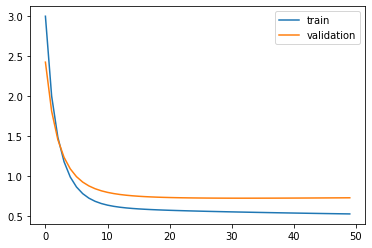

time: 212 ms (started: 2021-05-04 20:16:20 +00:00)


In [172]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Digital_Music.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [173]:
results_df_sgd = pickle.load(open('/content/Digital_Music_5_results_summary',"rb"))
# results_df_sgd['df_name'] = 'SGD_Software_5' # correcting error
results_df_sgd

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Digital_Music.p,51999,12707,0.572678,0.727261,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 2)",5,2
1,SGD_Digital_Music.p,51999,12707,0.572678,0.727261,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 5)",5,2
2,SGD_Digital_Music.p,51999,12707,0.572678,0.727261,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 20)",5,2
3,SGD_Digital_Music.p,51999,12707,0.552769,0.727106,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 2)",5,2
4,SGD_Digital_Music.p,51999,12707,0.552769,0.727106,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 5)",5,2
5,SGD_Digital_Music.p,51999,12707,0.552769,0.727106,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 20)",5,2


time: 35.7 ms (started: 2021-05-04 20:16:48 +00:00)


## Musical Instruments 2018 dataset

no. of users 9993
no. of items 13105
train size 51648
test size 13149


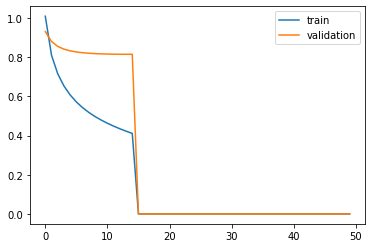

time: 207 ms (started: 2021-05-04 20:25:52 +00:00)


In [175]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Musical_Instruments.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
print(f'train size {len(model_sgd["train"])}')
print(f'test size {len(model_sgd["test"])}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

## SGD on 5-core datasets combined
1. Software
2. Patio, Lawn and Garden
3. Digital Music
4. Arts, Crafts and Saving

no. of users 99762
no. of items 45900
train size 653027
test size 162679


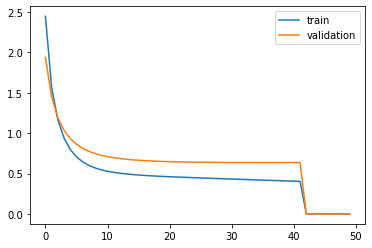

time: 287 ms (started: 2021-05-04 20:31:38 +00:00)


In [176]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Combined_Software_DigitalMusic_Patio_ArtsCrafts_5_core.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
print(f'train size {len(model_sgd["train"])}')
print(f'test size {len(model_sgd["test"])}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [177]:
results_df_sgd = pickle.load(open('/content/5_core_Combined_results_summary_2.p',"rb"))
# results_df_sgd['df_name'] = 'SGD_Software_5' # correcting error
results_df_sgd

,df_name,Train_size,Test_size,Train_MAE,Test_MAE,Hyperparam_tried,Best_param,Min_User,Min_Item
0,SGD_Combined_Software_DigitalMusic_Patio_ArtsC...,653027,162679,0.418462,0.636135,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 5)",3,2
1,SGD_Combined_Software_DigitalMusic_Patio_ArtsC...,653027,162679,0.418462,0.636135,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 20)",3,2
2,SGD_Combined_Software_DigitalMusic_Patio_ArtsC...,653027,162679,0.418462,0.636135,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.1, 50)",3,2
3,SGD_Combined_Software_DigitalMusic_Patio_ArtsC...,653027,162679,0.418462,0.636135,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 5)",3,2
4,SGD_Combined_Software_DigitalMusic_Patio_ArtsC...,653027,162679,0.418462,0.636135,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 20)",3,2
5,SGD_Combined_Software_DigitalMusic_Patio_ArtsC...,653027,162679,0.418462,0.636135,"{'lr': [0.01], 'reg': [0.1, 0.01], 'factors': ...","(0.01, 0.01, 50)",3,2


time: 40.1 ms (started: 2021-05-04 20:32:18 +00:00)


## Appliances 2018 dataset - SGD

no. of users 11682
no. of items 60840
train size 115670
test size 27707


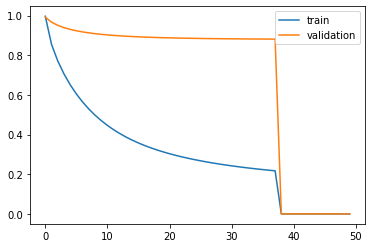

time: 226 ms (started: 2021-05-04 20:48:01 +00:00)


In [182]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Applicances.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
print(f'train size {len(model_sgd["train"])}')
print(f'test size {len(model_sgd["test"])}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

In [181]:
model_sgd.keys()

dict_keys(['name', 'user_vectors', 'item_vectors', 'hyperparameters', 'train', 'test', 'train_mse', 'train_mae', 'test_mse', 'test_mae', 'user_mapping', 'item_mapping'])

time: 5.01 ms (started: 2021-05-04 20:47:44 +00:00)


## Luxury Beauty 2018 dataset

no. of users 10621
no. of items 415231
train size 427070
test size 106741
best validation MAE 1.255884785803772


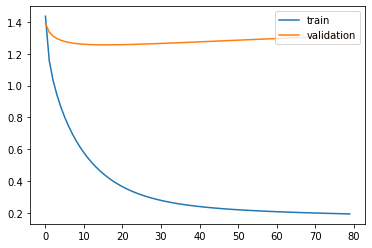

time: 434 ms (started: 2021-05-04 20:51:57 +00:00)


In [187]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Luxury_Beauty.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
print(f'train size {len(model_sgd["train"])}')
print(f'test size {len(model_sgd["test"])}')
print(f'best validation MAE {model_sgd["best_test_mae"]/len(model_sgd["test"])}')
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

## SGD and ALS on 5-core 2018 datasets
1. Industrial and Scientific
2. Luxury Beauty
3. Software 
4. Prime Pantry


no. of users 29499
no. of items 12512
train size 194554
test size 48329


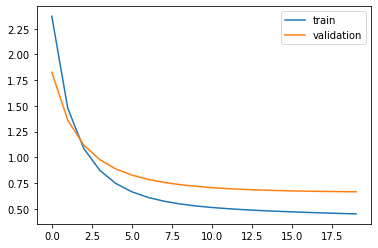

time: 238 ms (started: 2021-05-04 21:02:35 +00:00)


In [189]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_5_core.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
print(f'train size {len(model_sgd["train"])}')
print(f'test size {len(model_sgd["test"])}')

plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

no. of users 29499
no. of items 12512
train size 194554
test size 48329


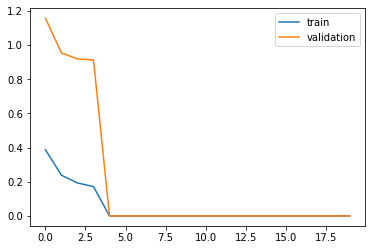

time: 232 ms (started: 2021-05-04 21:04:49 +00:00)


In [190]:
# read model and plot graph
model_als = pickle.load(open('/content/ALS_5_core.p','rb'))
train_set = model_als['train']
test_set = model_als['test']
train_mae = model_als['train_mae']
test_mae = model_als['test_mae']
print(f'no. of users {len(model_als["user_mapping"].keys())}')
print(f'no. of items {len(model_als["item_mapping"].keys())}')
print(f'train size {len(model_als["train"])}')
print(f'test size {len(model_als["test"])}')

plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

## SGD Gourmet 2018 Dataset

no. of users 29499
no. of items 12512
train size 194554
test size 48329


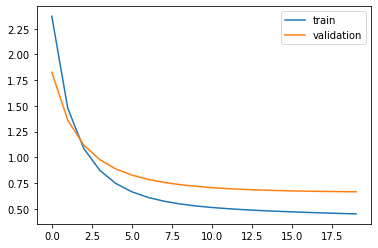

time: 218 ms (started: 2021-05-04 21:10:35 +00:00)


In [191]:
# read model and plot graph
model_sgd = pickle.load(open('/content/SGD_Gourmet.p','rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
print(f'no. of users {len(model_sgd["user_mapping"].keys())}')
print(f'no. of items {len(model_sgd["item_mapping"].keys())}')
print(f'train size {len(model_sgd["train"])}')
print(f'test size {len(model_sgd["test"])}')

plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')